In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, ks_2samp, gaussian_kde
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


In [84]:
def target_distribution(q):
    return 0.3 * norm.pdf(q, loc=4, scale=np.sqrt(0.3)) + \
           0.7 * norm.pdf(q, loc=7, scale=np.sqrt(2))

def U(q):
    pi_q = target_distribution(q)

    pi_q = np.clip(pi_q, 1e-10, None)
    return -np.log(pi_q)

def grad_U(q):
    sigma1_sq = 0.3
    sigma2_sq = 2.0
    
    log_a = -0.5 * (q-4)**2 / sigma1_sq - 0.5*np.log(2*np.pi*sigma1_sq) + np.log(0.3)
    log_b = -0.5 * (q-7)**2 / sigma2_sq - 0.5*np.log(2*np.pi*sigma2_sq) + np.log(0.7)

    max_log = max(log_a, log_b)
    log_sum = max_log + np.log(np.exp(log_a - max_log) + np.exp(log_b - max_log))

    w1 = np.exp(log_a - log_sum)  # a/(a+b)
    w2 = np.exp(log_b - log_sum)  # b/(a+b)

    grad = w1 * (-(q-4)/sigma1_sq) + w2 * (-(q-7)/sigma2_sq)
    
    return grad

In [85]:
# HMC 实现
def hmc_sampler(current_q, epsilon, L, M=1):
    current_p = np.random.normal(0, np.sqrt(M))
    
    # 蛙跳积分
    q = float(current_q)
    p = float(current_p)

    p -= epsilon/2 * grad_U(q)
    
    for _ in range(L):
        q += epsilon * p / M
        
        if _ < L-1:
            p -= epsilon * grad_U(q)

    p -= epsilon/2 * grad_U(q)
    

    current_H = U(current_q) + current_p**2/(2*M)
    proposed_H = U(q) + p**2/(2*M)
    
    if np.random.uniform(0, 1) < np.exp(current_H - proposed_H):
        return q, True 
    else:
        return current_q, False

In [86]:
def run_hmc(n_samples, epsilon=0.3, L=20, burn_in=500):
    samples = np.zeros(n_samples + burn_in)
    samples[0] = 5.0
    
    accept_count = 0
    
    for i in range(1, n_samples + burn_in):
        samples[i], accepted = hmc_sampler(samples[i-1], epsilon, L)
        if accepted:
            accept_count += 1
    
    acceptance_rate = accept_count / (n_samples + burn_in)
    print(f"接受率: {acceptance_rate:.3f}")

    return samples[burn_in:], acceptance_rate

In [95]:
epsilons = [0.1, 0.2, 0.3, 0.4]
Ls = [10, 15, 20, 25]

for eps in epsilons:
    for L_val in Ls:
        test_samples, acc_rate = run_hmc(
            n_samples=2000, 
            epsilon=eps, 
            L=L_val, 
            burn_in=200
        )
        ks_stat, _ = ks_2samp(test_samples[:1000], true_samples[:1000])
        print(f"epsilon={eps:.1f}, L={L_val}: 接受率={acc_rate:.3f}, KS={ks_stat:.4f}")

# 从结果可知，选择接受率较高的步长和跳蛙步数

接受率: 0.585
epsilon=0.1, L=10: 接受率=0.585, KS=0.1490
接受率: 0.456
epsilon=0.1, L=15: 接受率=0.456, KS=0.2170
接受率: 0.411
epsilon=0.1, L=20: 接受率=0.411, KS=0.1510
接受率: 0.445
epsilon=0.1, L=25: 接受率=0.445, KS=0.1080
接受率: 0.457
epsilon=0.2, L=10: 接受率=0.457, KS=0.0760
接受率: 0.380
epsilon=0.2, L=15: 接受率=0.380, KS=0.0760
接受率: 0.303
epsilon=0.2, L=20: 接受率=0.303, KS=0.0900
接受率: 0.288
epsilon=0.2, L=25: 接受率=0.288, KS=0.0860
接受率: 0.414
epsilon=0.3, L=10: 接受率=0.414, KS=0.0710
接受率: 0.274
epsilon=0.3, L=15: 接受率=0.274, KS=0.1360
接受率: 0.214
epsilon=0.3, L=20: 接受率=0.214, KS=0.1640
接受率: 0.170
epsilon=0.3, L=25: 接受率=0.170, KS=0.5880
接受率: 0.267
epsilon=0.4, L=10: 接受率=0.267, KS=0.0920
接受率: 0.194
epsilon=0.4, L=15: 接受率=0.194, KS=0.1460
接受率: 0.291
epsilon=0.4, L=20: 接受率=0.291, KS=0.2700
接受率: 0.313
epsilon=0.4, L=25: 接受率=0.313, KS=0.2530


In [96]:
np.random.seed(42)

n_samples = 10000
epsilon = 0.1  # 步长
L = 10         # 蛙跳步数

samples, accept_rate = run_hmc(n_samples, epsilon, L, burn_in=1000)

true_samples = np.zeros(n_samples)
for i in range(n_samples):
    if np.random.rand() < 0.3:
        true_samples[i] = np.random.normal(4, np.sqrt(0.3))
    else:
        true_samples[i] = np.random.normal(7, np.sqrt(2))

接受率: 0.610


In [97]:
print("\n误差指标：")

# 1. KS 检验
ks_stat, ks_pvalue = ks_2samp(samples, true_samples)
print(f"KS 统计量: {ks_stat:.4f}")
print(f"KS p值: {ks_pvalue:.4f}")

# 2. 分位数比较
quantiles = np.linspace(0.05, 0.95, 10)
sample_quantiles = np.percentile(samples, quantiles*100)
true_quantiles = np.percentile(true_samples, quantiles*100)
quantile_mse = np.mean((sample_quantiles - true_quantiles)**2)
print(f"分位数均方误差: {quantile_mse:.6f}")

# 3. 直方图对比的 TV 距离
hist_range = (0, 12)
hist_bins = 50
sample_hist, bin_edges = np.histogram(samples, bins=hist_bins, range=hist_range, density=True)
true_hist, _ = np.histogram(true_samples, bins=hist_bins, range=hist_range, density=True)

# 计算总变差距离
tv_distance = 0.5 * np.sum(np.abs(sample_hist - true_hist)) * (bin_edges[1]-bin_edges[0])
print(f"总变差距离: {tv_distance:.4f}")

# 4. 计算均值方差差异
sample_mean = np.mean(samples)
sample_var = np.var(samples)
true_mean = 0.3*4 + 0.7*7
true_var = 0.3*(0.3 + 4**2) + 0.7*(2 + 7**2) - true_mean**2

print(f"\n理论均值: {true_mean:.4f}, 采样均值: {sample_mean:.4f}, 差异: {abs(sample_mean-true_mean):.4f}")
print(f"理论方差: {true_var:.4f}, 采样方差: {sample_var:.4f}, 差异: {abs(sample_var-true_var):.4f}")


误差指标：
KS 统计量: 0.0240
KS p值: 0.0063
分位数均方误差: 0.009439
总变差距离: 0.0463

理论均值: 6.1000, 采样均值: 6.1808, 差异: 0.0808
理论方差: 3.3800, 采样方差: 3.2826, 差异: 0.0974


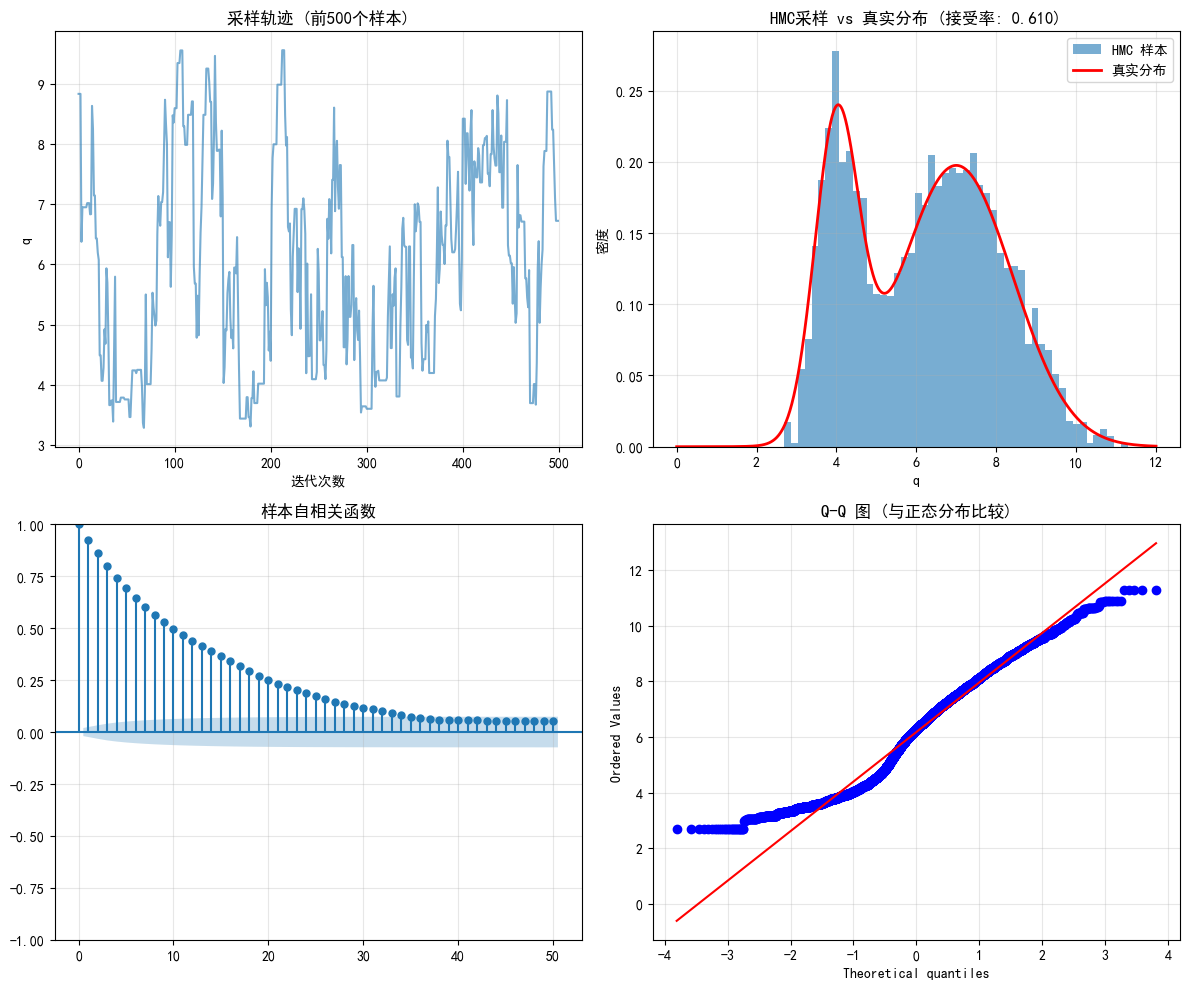

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 子图1: 采样轨迹
axes[0, 0].plot(samples[:500], alpha=0.6)
axes[0, 0].set_xlabel('迭代次数')
axes[0, 0].set_ylabel('q')
axes[0, 0].set_title('采样轨迹 (前500个样本)')
axes[0, 0].grid(True, alpha=0.3)

# 子图2: 直方图对比
x_plot = np.linspace(0, 12, 1000)
axes[0, 1].hist(samples, bins=50, density=True, alpha=0.6, label='HMC 样本')
axes[0, 1].plot(x_plot, target_distribution(x_plot), 'r-', linewidth=2, label='真实分布')
axes[0, 1].set_xlabel('q')
axes[0, 1].set_ylabel('密度')
axes[0, 1].set_title(f'HMC采样 vs 真实分布 (接受率: {accept_rate:.3f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 子图3: 自相关函数
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(samples, lags=50, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('样本自相关函数')
axes[1, 0].grid(True, alpha=0.3)

# 子图4: Q-Q 图
from scipy.stats import probplot
probplot(samples, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q 图 (与正态分布比较)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hmc_mixture_gaussian.png', dpi=150, bbox_inches='tight')
plt.show()